In [1]:
import pandas as pd
import json
from pandas import json_normalize
from astropy.table import QTable

from lvmtipo.actors import lvm
from lvmagp.images import Image
from lvmagp.actor.statemachine import ActorState, ActorStateMachine
from lvmagp.guide.worker import GuiderWorker
from lvmagp.json_serializers import deserialize_skycoord

from IPython.display import display, clear_output

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot(image, ref_image):
    fig,ax1 = plt.subplots(figsize=(8, 4.5))
    ax1.imshow(image.data,norm=LogNorm(vmin=50, vmax=500))
    ax1.plot(image.catalog["x"],image.catalog["y"],"o",markerfacecolor="none",markeredgecolor="r",ms=20)
    if ref_image:
        ax1.plot(ref_image.catalog["x"],ref_image.catalog["y"],"o",markerfacecolor="none",markeredgecolor="w",ms=16)
    plt.show()


In [3]:
scraper = None

{'radec_diff': [-0.15219785096921232, 0.07862178608621599], 'axis_diff': [-0.09761294988948066, -0.1407902147529505]}
['/home/jovyan/work/work/agcam/skyw/west/20230225/lvm.skyw.agcam.west_00000256.fits', '/home/jovyan/work/work/agcam/skyw/east/20230225/lvm.skyw.agcam.east_00000256.fits']
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (116.09343532, -9.55213571)>


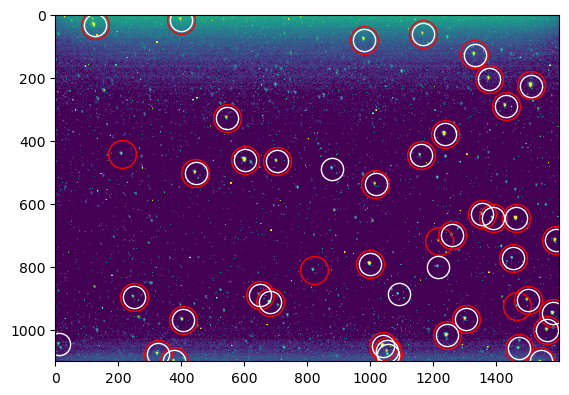

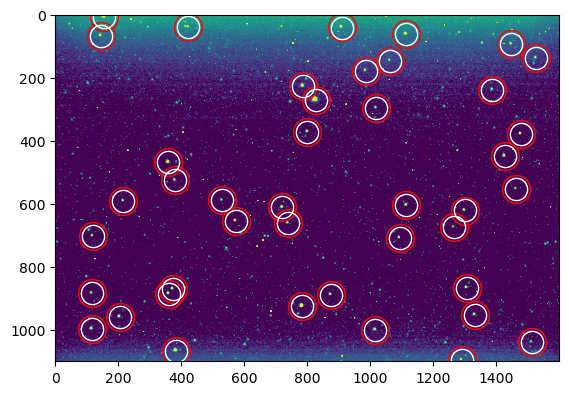

{'state': 'IDLE'}


In [4]:
import yaml
from lvmtipo.scraper import Scraper

tel="skyw"

config = lambda tel: f"""
lvm.{tel}.ag: null
"""

def handle_data(data):
    # gets executed on scraper_event
    print(data)
    if "ag" in data.sender and 'isreference' in data.keys():
        try:
            if "failure" in data.keys():
                print(data['failure'])

            isreference = data['isreference']
            state = data['state']
            filenames = data['filenames']
            images = [Image.from_file(f) for f in filenames]
            catalogs = [QTable.from_pandas(pd.DataFrame.from_dict(d, orient='index').T) for d in data['catalog']]
            for idx, img in enumerate(images):
                img.catalog = catalogs[idx]
                images[idx] = img
            if isreference:
                handle_data.reference_images = images   
            else:
                correction = data['correction']
            clear_output(wait=True)
        
            if not isreference:
                print(correction)
            print(filenames)
            print(deserialize_skycoord(data["position"]))
            for idx, img in enumerate(images):
                plot(img, handle_data.reference_images[idx] if handle_data.reference_images else None)

        except Exception as ex:
            print(ex)

handle_data.reference_images = None

if scraper: await scraper.stop()
scraper = await Scraper(yaml.safe_load(config(tel)), callback=handle_data).start()
